# **Image Captioning Using CNN and RNN**
This project combines computer vision and natural language processing techniques to create a model that generates descriptive captions for images. We'll preprocess the dataset, extract features using a pretrained CNN, and generate captions using an RNN.

---

## **1. Import Required Libraries**
We'll start by importing the required libraries for this project.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import pickle

## **2. Load Dataset from Google Drive**
First, we'll load the dataset containing images and their captions.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip the dataset
!unzip -q '/content/drive/MyDrive/archive (7).zip' -d '/content/dataset'

# Check the dataset structure
!ls /content/dataset

captions.txt  Images


## **3. Explore the Dataset**
Check the structure of the dataset and captions file.

In [5]:
# Display files in the dataset directory
!ls /content/dataset

# Display the first few lines of the captions file
!head /content/dataset/captions.txt

captions.txt  Images
image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .


## **4. Load and Process Captions**
Process the captions file to create a mapping between images and their captions.

In [6]:
# Path to captions file
captions_path = "/content/dataset/captions.txt"

# Load and process captions file
captions = pd.read_csv(captions_path)
captions.columns = ["image", "caption"]

# Display the first few rows of the captions file
captions.head()

# Group captions by image ID
image_captions = {}
for _, row in captions.iterrows():
    img_id = row['image'].split('.')[0]  # Remove file extension
    caption = 'startseq ' + row['caption'] + ' endseq'  # Add start and end tokens
    if img_id not in image_captions:
        image_captions[img_id] = []
    image_captions[img_id].append(caption)

# Display some image-caption pairs
for key, value in list(image_captions.items())[:5]:
    print(f"{key}: {value}")

1000268201_693b08cb0e: ['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq', 'startseq A girl going into a wooden building . endseq', 'startseq A little girl climbing into a wooden playhouse . endseq', 'startseq A little girl climbing the stairs to her playhouse . endseq', 'startseq A little girl in a pink dress going into a wooden cabin . endseq']
1001773457_577c3a7d70: ['startseq A black dog and a spotted dog are fighting endseq', 'startseq A black dog and a tri-colored dog playing with each other on the road . endseq', 'startseq A black dog and a white dog with brown spots are staring at each other in the street . endseq', 'startseq Two dogs of different breeds looking at each other on the road . endseq', 'startseq Two dogs on pavement moving toward each other . endseq']
1002674143_1b742ab4b8: ['startseq A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . endseq', 'startseq A little girl is sitting in fr

## **5. Preprocess Images**
Use the pretrained InceptionV3 model to extract features from the images.

In [7]:
# Load the pretrained InceptionV3 model
inception_model = InceptionV3(weights="imagenet")
cnn_model = Model(inputs=inception_model.input, outputs=inception_model.layers[-2].output)  # Remove the top layer

# Function to preprocess a single image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))  # Resize to InceptionV3 input size
    img = img_to_array(img) / 255.0  # Normalize pixel values
    return np.expand_dims(img, axis=0)

# Extract features for all images
image_features = {}
image_dir = "/content/dataset/Images"
for img_file in os.listdir(image_dir):
    img_id = img_file.split('.')[0]  # Remove file extension
    img_path = os.path.join(image_dir, img_file)
    processed_img = preprocess_image(img_path)
    features = cnn_model.predict(processed_img, verbose=0)
    image_features[img_id] = features

# Save extracted features for future use
np.save("image_features.npy", image_features)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## **6. Tokenize Captions**
Convert captions into integer sequences using a tokenizer.

In [8]:
# Flatten all captions into a single list
all_captions = [caption for captions in image_captions.values() for caption in captions]

# Create and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Save the tokenizer for future use
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 8496


## **7. Convert Captions to Sequences**
Convert captions to input-output pairs for training. Use sparse categorical labels for efficiency.

In [9]:
# Find the maximum caption length
max_length = max(len(caption.split()) for caption in all_captions)

# Function to create input-output pairs
def create_sparse_sequences(tokenizer, max_length, image_captions, features):
    X1, X2, y = [], [], []
    for img_id, captions in image_captions.items():
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption])[0]  # Convert to sequence
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  # Pad input sequence
                X1.append(features[img_id][0])  # Image feature
                X2.append(in_seq)  # Input sequence
                y.append(out_seq)  # Sparse label
    return np.array(X1), np.array(X2), np.array(y)

# Load extracted features
features = np.load("image_features.npy", allow_pickle=True).item()

# Create sequences
X1, X2, y = create_sparse_sequences(tokenizer, max_length, image_captions, features)

# Display shapes
print("Input Image Features Shape (X1):", X1.shape)
print("Input Sequences Shape (X2):", X2.shape)
print("Output Shape (y):", y.shape)

Input Image Features Shape (X1): (478078, 2048)
Input Sequences Shape (X2): (478078, 40)
Output Shape (y): (478078,)


## **8. Build the Captioning Model**
Build and compile the image captioning model using CNN + RNN.

In [11]:
# Define the model
def build_model(vocab_size, max_length):
    # Image feature extractor
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Sequence processor
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model

# Compile the model
model = build_model(vocab_size, max_length)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 40, 256)        │      2,174,976 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 2048)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 40, 256)        │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 40)             │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ dropout_3[0][0],       │
│                           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         65,792 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8496)           │      2,183,472 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,474,096 (20.88 MB)

 Trainable params: 5,474,096 (20.88 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Function to create input-output pairs with right-padded sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

def create_sparse_sequences(tokenizer, max_length, image_captions, features):
    X1, X2, y = [], [], []
    for img_id, captions in image_captions.items():
        for caption in captions:
            seq = tokenizer.texts_to_sequences([caption])[0]  # Convert caption to sequence
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # Right-pad the input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                X1.append(features[img_id][0])  # Image feature
                X2.append(in_seq)  # Input sequence
                y.append(out_seq)  # Output token
    return np.array(X1), np.array(X2), np.array(y)

# Generate input-output pairs with right-padding
X1, X2, y = create_sparse_sequences(tokenizer, max_length, image_captions, features)

## **9. Train the Model**
Train the model using the prepared input-output pairs.

In [13]:
# Train the model
history = model.fit(
    [X1, X2],  # Input: Image features and sequences
    y,         # Output: Next word in the sequence
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 79s 12ms/step - loss: 4.3078 - val_loss: 3.4564
Epoch 2/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - loss: 3.2130 - val_loss: 3.3383
Epoch 3/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 2.9640 - val_loss: 3.3343
Epoch 4/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - loss: 2.8133 - val_loss: 3.3563
Epoch 5/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 2.7203 - val_loss: 3.3668
Epoch 6/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - loss: 2.6609 - val_loss: 3.4185
Epoch 7/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 2.6054 - val_loss: 3.4678
Epoch 8/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - loss: 2.5672 - val_loss: 3.5028
Epoch 9/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - loss: 2.5394 - val_loss: 3.5410
Epoch 10/10
5976/5976 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - loss: 2.5222 - val_loss: 3.5451


# **🔹 10. Evaluate and Visualize Model Performance**

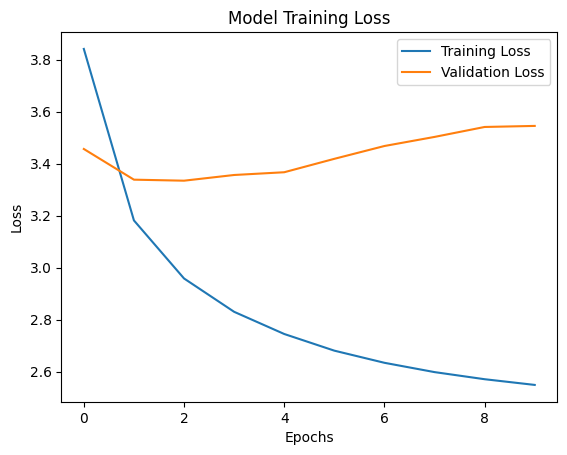

In [14]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Training Loss')
plt.show()

## **10. Generating Captions for New Images**
Now, let's generate captions for unseen images using the trained model.

### **10.1. Function to Generate Captions**

In [16]:
def generate_caption(model, tokenizer, max_length, image_feature):
    in_text = '<start>'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([image_feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = tokenizer.index_word.get(y_pred, None)
        if word is None or word == '<end>':
            break
        in_text += ' ' + word
    return in_text.replace('<start>', '').strip()

### **10.2. Predict Caption for a New Image**
Now, we will load a new image, extract its features using the trained CNN model, and generate a caption.

In [42]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess an image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(299, 299))  # Resize to match model input
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

# Choose a test image
test_image_path = "/content/dataset/Images/1288909046_d2b2b62607.jpg"

# Extract image features using trained CNN model
image_feature = cnn_model.predict(preprocess_image(test_image_path))

# Generate a caption
generated_caption = generate_caption(model, tokenizer, max_length, image_feature)

# Display the result
print("Generated Caption:", generated_caption)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Generated Caption: a dog sled endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


## **11. Visualizing the Image with Caption**
To make the results more intuitive, let's visualize the test image along with the predicted caption.

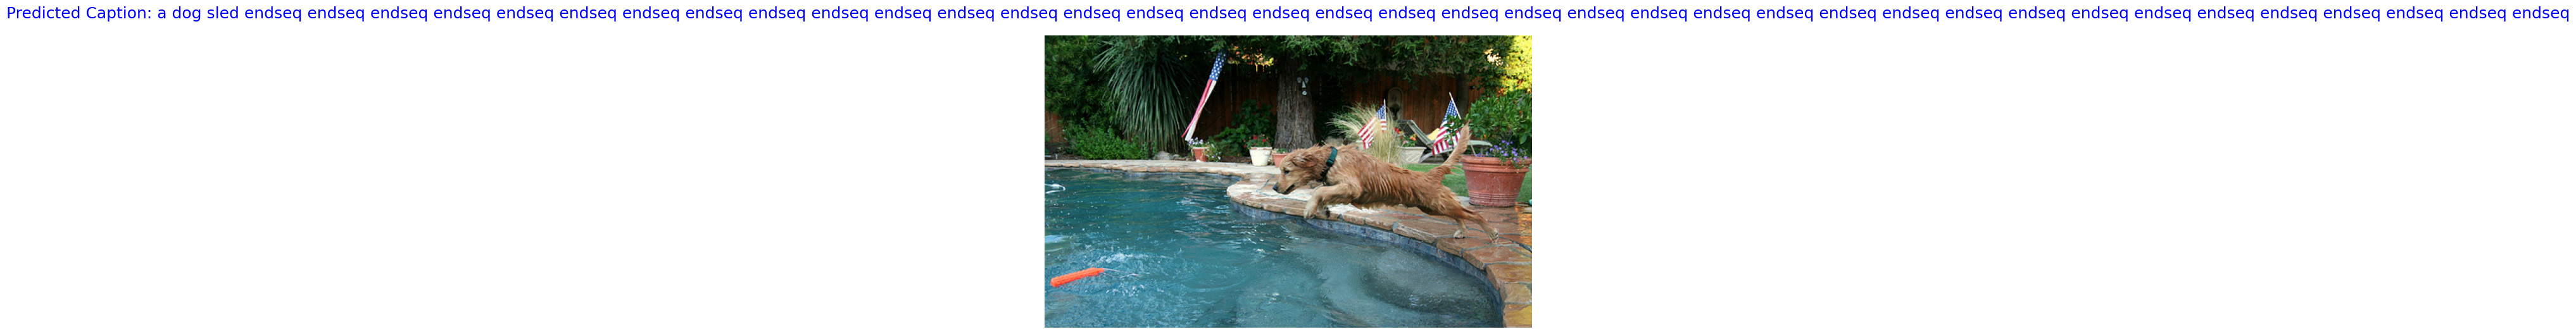

In [43]:
import matplotlib.pyplot as plt
import cv2

# Load the image
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create figure and adjust title size
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")

# Increase font size - try 16, 18, or 20 depending on your preference
plt.title(f"Predicted Caption: {generated_caption}", fontsize=18, color='blue', pad=20)

# Adjust layout to prevent title cutoff
plt.tight_layout()
plt.show()

## **12. Save and Export the Model**
Once the model is trained and tested, it is essential to save it for future use.

In [44]:
# Save the trained model
model.save("/content/image_captioning_model.h5")

# Save the tokenizer
import pickle
with open("/content/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!
